# Segmentation map으로 도로 이미지 만들기

루브릭
1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.  
데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.
2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.  
U-Net generator, discriminator 모델 구현이 완료되어 train_step의 output을 확인하고 개선하였다.
3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.  
10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다.

수행 조건
1. 데이터에 한 가지 이상의 augmentation사용
2. U-Net Generator 사용
3. 테스트 데이터는 val폴더 내 이미지 사용
4. 1개 이상의 이미지에 대한 테스트 과정을 거친 후 그 결과를 스케치, 생성 사진, 실제 사진 순서로 나란히 시각화
5. 10 epoch이상 학습+중간 손실 값에 대한 로그 남기기

In [1]:
# 파일 불러오기
import os

data_path = os.getenv('HOME')+'/aiffel/cityscapes/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


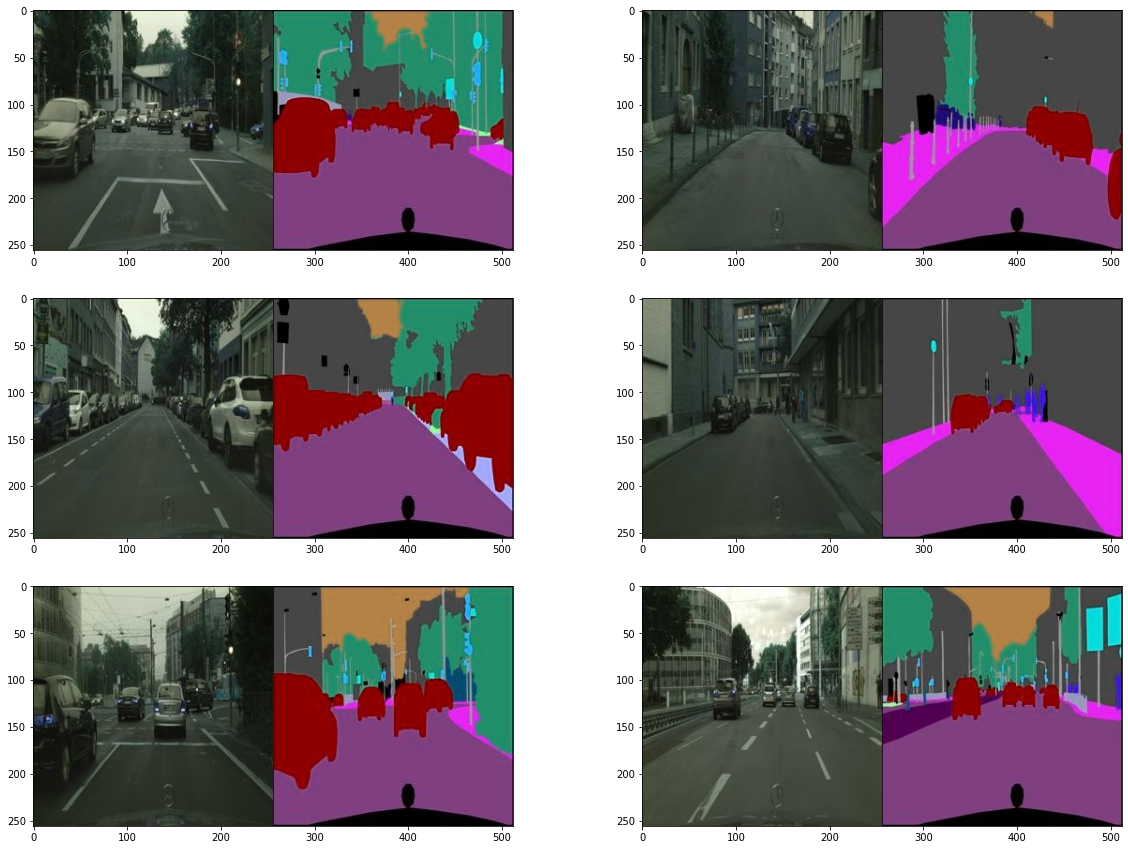

In [2]:
# 이미지 확인
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[i]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [3]:
# 파일 크기 확인
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


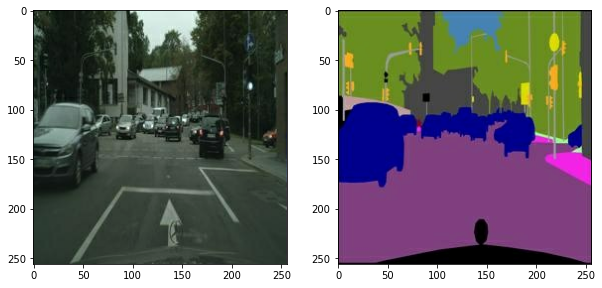

In [4]:
import tensorflow as tf

# 정규화
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

# 정규화된 데이터를 원본 값으로
def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

# 파일을 읽어들인 후 input과 ground truth로 나눔
def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

### data augmentation

50% 확률로 reflection padding과 constant padding이 넓이 30픽셀 만큼 적용된 다음,  
50% 확률로 이미지를 crop한 다음,  
50% 확률로 이미지를 가로로 뒤집은 다음,  
50% 확률로 이미지를 세로로 뒤집은 다음,  
50% 확률로 이미지를 90도 회전시킨다.  

In [5]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]

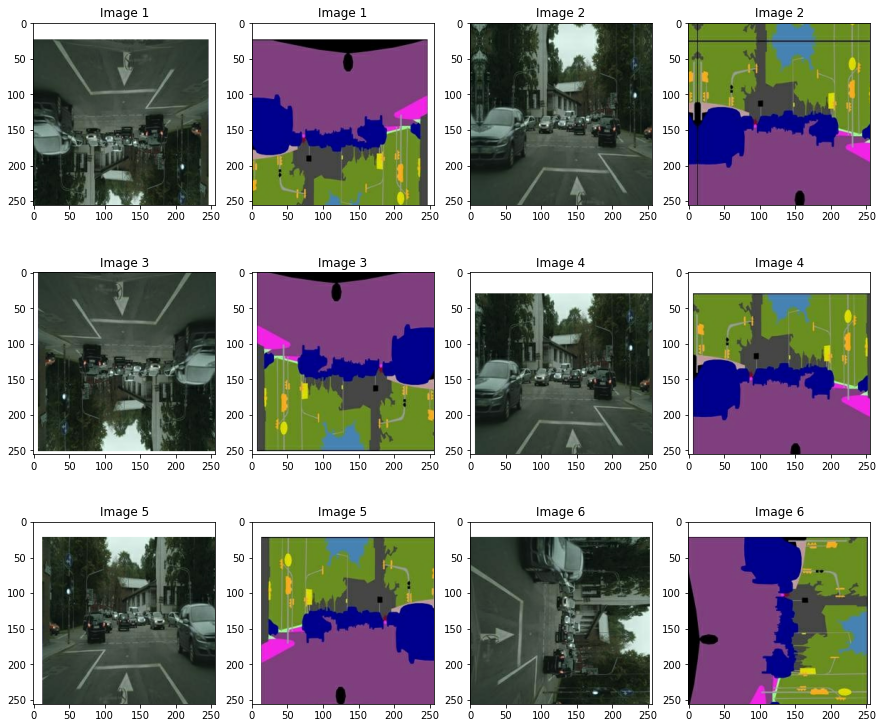

In [6]:
# augmentation이 잘 되었는지 확인
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

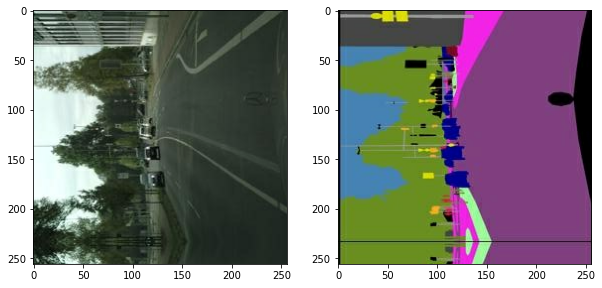

In [7]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

### U-Net Generator 구성

In [8]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [9]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [10]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

### dicriminator 구현하기

In [11]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [12]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [13]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

In [14]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [15]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [16]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [17]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.9112                     
L1_loss:0.3193                     
Discriminator_loss:1.1832

EPOCH[1] - STEP[20]                     
Generator_loss:0.9820                     
L1_loss:0.3169                     
Discriminator_loss:1.0150

EPOCH[1] - STEP[30]                     
Generator_loss:0.9506                     
L1_loss:0.3168                     
Discriminator_loss:0.8879

EPOCH[1] - STEP[40]                     
Generator_loss:1.1849                     
L1_loss:0.2555                     
Discriminator_loss:0.8560

EPOCH[1] - STEP[50]                     
Generator_loss:1.6573                     
L1_loss:0.2668                     
Discriminator_loss:0.6861

EPOCH[1] - STEP[60]                     
Generator_loss:2.2271                     
L1_loss:0.2600                     
Discriminator_loss:0.7410

EPOCH[1] - STEP[70]                     
Generator_loss:2.3040                     
L1_loss:0.2295                    

EPOCH[3] - STEP[70]                     
Generator_loss:0.8332                     
L1_loss:0.2267                     
Discriminator_loss:0.9066

EPOCH[3] - STEP[80]                     
Generator_loss:0.8262                     
L1_loss:0.1688                     
Discriminator_loss:1.0115

EPOCH[3] - STEP[90]                     
Generator_loss:2.8912                     
L1_loss:0.1992                     
Discriminator_loss:1.2002

EPOCH[3] - STEP[100]                     
Generator_loss:2.2255                     
L1_loss:0.1923                     
Discriminator_loss:0.5750

EPOCH[3] - STEP[110]                     
Generator_loss:1.4872                     
L1_loss:0.1999                     
Discriminator_loss:0.9457

EPOCH[3] - STEP[120]                     
Generator_loss:0.9530                     
L1_loss:0.2638                     
Discriminator_loss:0.7577

EPOCH[3] - STEP[130]                     
Generator_loss:0.7953                     
L1_loss:0.2082                

EPOCH[5] - STEP[130]                     
Generator_loss:2.2721                     
L1_loss:0.1829                     
Discriminator_loss:0.8023

EPOCH[5] - STEP[140]                     
Generator_loss:1.8656                     
L1_loss:0.2137                     
Discriminator_loss:0.8339

EPOCH[5] - STEP[150]                     
Generator_loss:2.5917                     
L1_loss:0.1683                     
Discriminator_loss:1.2963

EPOCH[5] - STEP[160]                     
Generator_loss:2.3264                     
L1_loss:0.2184                     
Discriminator_loss:0.4237

EPOCH[5] - STEP[170]                     
Generator_loss:3.2760                     
L1_loss:0.1806                     
Discriminator_loss:0.3962

EPOCH[5] - STEP[180]                     
Generator_loss:1.3624                     
L1_loss:0.2084                     
Discriminator_loss:0.5812

EPOCH[5] - STEP[190]                     
Generator_loss:1.2220                     
L1_loss:0.1899             

EPOCH[7] - STEP[190]                     
Generator_loss:2.0511                     
L1_loss:0.1907                     
Discriminator_loss:0.5416

EPOCH[7] - STEP[200]                     
Generator_loss:2.4090                     
L1_loss:0.1759                     
Discriminator_loss:1.0388

EPOCH[7] - STEP[210]                     
Generator_loss:3.2478                     
L1_loss:0.1924                     
Discriminator_loss:0.2831

EPOCH[7] - STEP[220]                     
Generator_loss:2.1627                     
L1_loss:0.1676                     
Discriminator_loss:1.5034

EPOCH[7] - STEP[230]                     
Generator_loss:1.5242                     
L1_loss:0.2146                     
Discriminator_loss:0.6844

EPOCH[7] - STEP[240]                     
Generator_loss:1.1789                     
L1_loss:0.1815                     
Discriminator_loss:0.6550

EPOCH[7] - STEP[250]                     
Generator_loss:1.8388                     
L1_loss:0.1819             

EPOCH[9] - STEP[250]                     
Generator_loss:2.3341                     
L1_loss:0.1490                     
Discriminator_loss:0.7320

EPOCH[10] - STEP[10]                     
Generator_loss:2.7859                     
L1_loss:0.2296                     
Discriminator_loss:0.1222

EPOCH[10] - STEP[20]                     
Generator_loss:1.1452                     
L1_loss:0.1789                     
Discriminator_loss:0.5978

EPOCH[10] - STEP[30]                     
Generator_loss:1.0216                     
L1_loss:0.1891                     
Discriminator_loss:0.7085

EPOCH[10] - STEP[40]                     
Generator_loss:1.8948                     
L1_loss:0.1760                     
Discriminator_loss:0.4683

EPOCH[10] - STEP[50]                     
Generator_loss:1.1481                     
L1_loss:0.1893                     
Discriminator_loss:0.7787

EPOCH[10] - STEP[60]                     
Generator_loss:2.7076                     
L1_loss:0.2178             

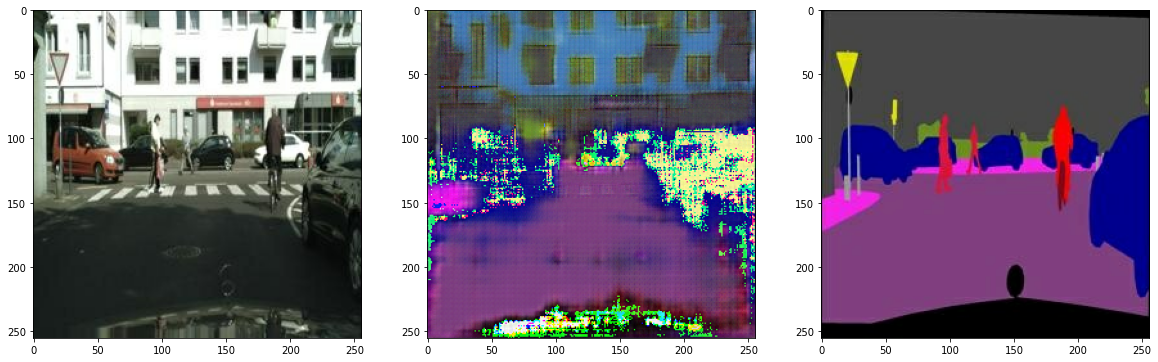

In [22]:
test_ind = 1

data_path_val = os.getenv('HOME')+'/aiffel/cityscapes/cityscapes/val/'

f = data_path_val + os.listdir(data_path_val)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

역시 epoch이 적어서 그런가? 제대로 된 채색이 이루어지지 않았다.  
  
회고  
한번 전체적인 구조를 pix2pix를 볼 수 있는 기회였다. 자력으로 코딩을 하지는 못했지만 코드를 한번 쭉 보면서 어떤 순서로 모델링이 되어야 하는지, 어떻게 짜면 좋을지는 익힐 수 있었던 것 같다. 어차피 하려는 aiffelthon의 주제와도 밀접한 관련이 있으니, 시간 나는 대로 코드를 복습하고 직접 작성할 수 있는 수준까지 이르기를 바란다.